In [1]:
import numpy as np
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import MinMaxScaler

In [2]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']

data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')
#data_frame = data_frame.sample(frac=1).reset_index(drop=True)

columns_categories = pandas.DataFrame()

for c in categories_columns:
    column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')
    columns_categories = pandas.concat((columns_categories, column), axis=1)

data_frame.drop(columns=categories_columns, inplace=True)
data_frame = pandas.concat([data_frame, columns_categories], axis=1)

outliers = data_frame[data_frame[column_to_predict] == 500001].index
data_frame.drop(outliers, inplace=True)

for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)
        
#columns_to_remove = ['households', 'total_bedrooms', column_to_predict]
#columns_to_remove = ['ocean_proximity', 'population', 'total_rooms', column_to_predict]
columns_to_remove = ['latitude', 'population', 'total_rooms']
#columns_to_remove = ['ocean_proximity']

data_frame.drop(columns=columns_to_remove, inplace=True)

data_frame

,longitude,housing_median_age,total_bedrooms,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.23,41.0,129.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,21.0,1106.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,52.0,190.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,52.0,235.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,52.0,280.0,259.0,3.8462,342200.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,25.0,374.0,330.0,1.5603,78100.0,0,1,0,0,0
20636,-121.21,18.0,150.0,114.0,2.5568,77100.0,0,1,0,0,0
20637,-121.22,17.0,485.0,433.0,1.7000,92300.0,0,1,0,0,0
20638,-121.32,18.0,409.0,349.0,1.8672,84700.0,0,1,0,0,0


In [3]:
column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
cols = list(range(0, data_frame.shape[1]))
cols.remove(column_to_predict_idx)

scaler = MinMaxScaler()
scaler.fit(data_frame)
data_frame = scaler.transform(data_frame)

X = data_frame[:, cols]
y = data_frame[:, column_to_predict_idx]

In [4]:
X.shape

(19675, 10)

In [5]:
y.shape

(19675,)

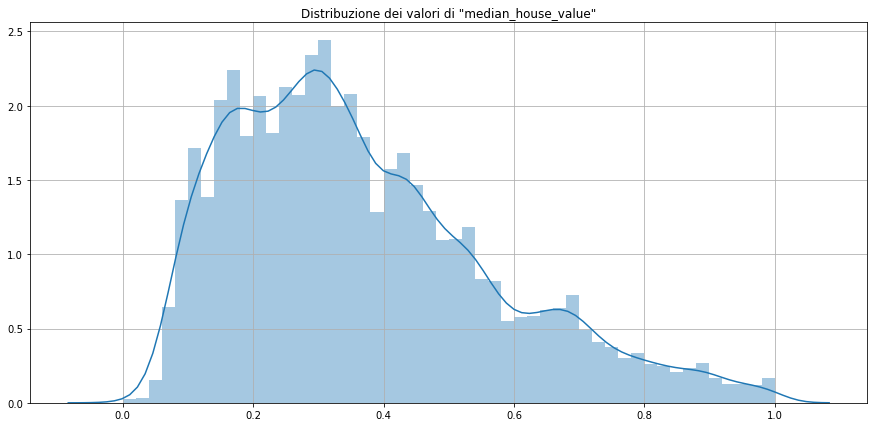

In [6]:
plt.figure(figsize=(15, 7))
plt.title('Distribuzione dei valori di "median_house_value"')

seaborn.distplot(y)

plt.grid()
plt.show()

### Cross validation

In [7]:
RMS = 'neg_mean_squared_error'
alpha_vals = np.linspace(0.000001, 1, 100)

regressor = Ridge(fit_intercept=True, normalize=True)
train_score__c, val_score__c = validation_curve(regressor, X, y, 'alpha', alpha_vals, cv=5, scoring=RMS, n_jobs=-1)

In [8]:
train_score_mean__c = -np.mean(train_score__c, axis=1)
train_score_std__c = np.std(train_score__c, axis=1)
val_score_mean__c = -np.mean(val_score__c, axis=1)
val_score_std__c = np.std(val_score__c, axis=1)

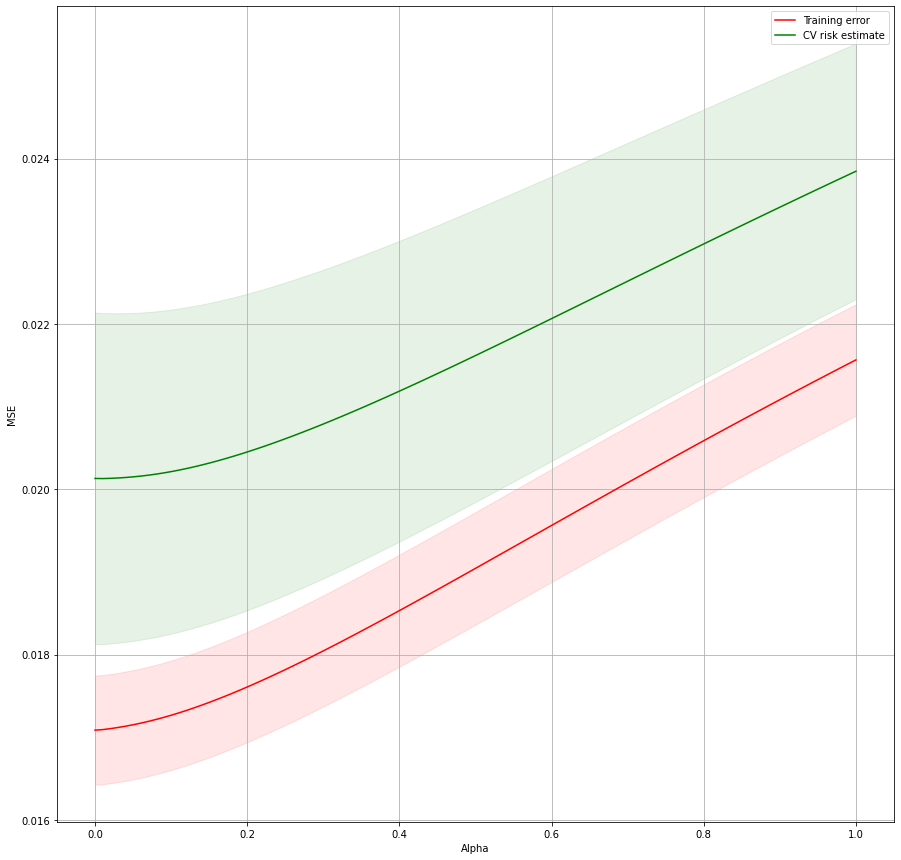

In [9]:
plt.figure(figsize=(15, 15))

plt.fill_between(alpha_vals, train_score_mean__c - train_score_std__c, train_score_mean__c + train_score_std__c, alpha=0.1, color="r")
plt.fill_between(alpha_vals, val_score_mean__c - val_score_std__c, val_score_mean__c + val_score_std__c, alpha=0.1, color="g")

plt.plot(alpha_vals, train_score_mean__c, color="r", label="Training error")
plt.plot(alpha_vals, val_score_mean__c, color="g", label="CV risk estimate")

plt.xlabel('Alpha')
plt.ylabel('MSE')

plt.grid()
plt.legend()
plt.show()

In [10]:
best_alpha = alpha_vals[np.argmin(val_score_mean__c)]
print('Best α: ', best_alpha)

regressor.set_params(alpha = 0.000001)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

Best α:  0.010101999999999998


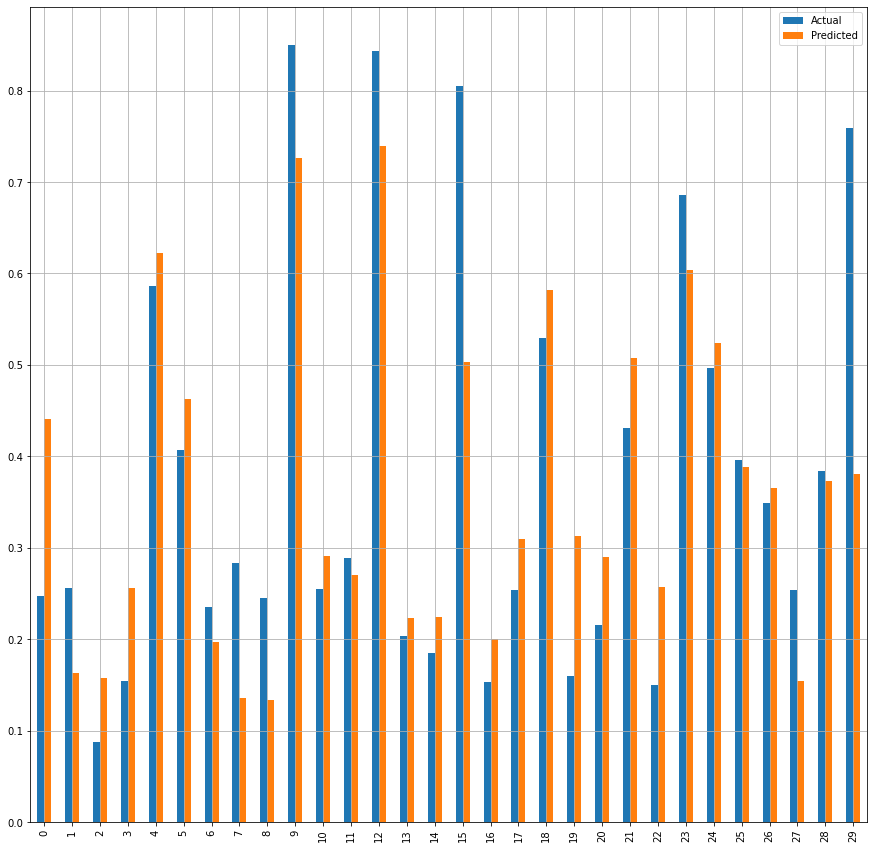

In [11]:
df = pandas.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(30)

df1.plot(kind='bar', figsize=(15, 15))
plt.grid()
plt.show()

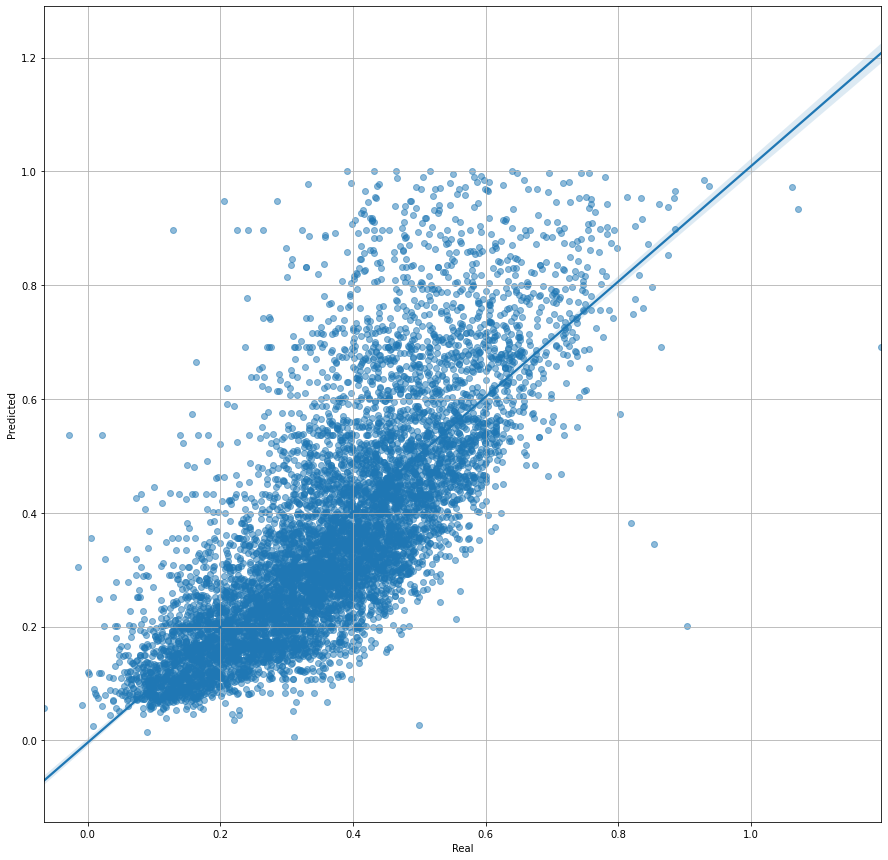

In [12]:
plt.figure(figsize=(15, 15))

seaborn.regplot(y_pred, y_test, scatter_kws={'alpha':0.5})

plt.xlabel('Real')
plt.ylabel('Predicted')

plt.grid()
plt.show()

In [13]:
print('R²:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R²: 0.5799644437307803
Mean Absolute Error: 0.09658739798919039
Mean Squared Error: 0.01715470184393414
Root Mean Squared Error: 0.13097595903040427
